<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_2Hweek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

## [MY CODE] 환경 확인용

In [ ]:
import torch

print(torch.__version__)
print(torch.version.cuda)  # PyTorch에서 사용하는 CUDA 버전
print(torch.cuda.is_available())  # GPU 사용 가능 여부


2.5.1+cu121
12.1
True


In [ ]:
!pip install datasets sacremoses

## [MY CODE] 라벨 추출 레이블 직접 사용

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    max_len = 400
    texts, labels = [], []

    for row in batch:
        # 텍스트와 라벨 추출
        labels.append(row['label'])  # 정답 레이블 직접 사용
        input_ids = tokenizer(row['text'], truncation=True, max_length=max_len).input_ids
        texts.append(torch.LongTensor(input_ids))

    # 패딩 처리
    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.FloatTensor(labels)  # Float로 변환 (BCEWithLogitsLoss 호환)

    return texts, labels


# 데이터 로더 정의
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


## Multi-head attention(MHA) 구현

## [MY CODE]
  - Multi를 위한 n_heads 추가
  - D가 H로 나눠 떨어지는 값이여야 하는 제약 조건

In [ ]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        assert d_model % n_heads == 0, "d_model은 n_heads로 나누어 떨어져야 합니다."

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # 1. Query, Key, Value 생성
        q = self.wq(x)  # (B, S, D)
        k = self.wk(x)  # (B, S, D)
        v = self.wv(x)  # (B, S, D)

        # 2. Reshape: (B, S, D) -> (B, S, H, D')
        q = q.view(batch_size, seq_len, self.n_heads, self.d_head)
        k = k.view(batch_size, seq_len, self.n_heads, self.d_head)
        v = v.view(batch_size, seq_len, self.n_heads, self.d_head)

        # 3. Transpose: (B, S, H, D') -> (B, H, S, D')
        q = q.transpose(1, 2)  # (B, H, S, D')
        k = k.transpose(1, 2)  # (B, H, S, D')
        v = v.transpose(1, 2)  # (B, H, S, D')

        # 4. Scaled Dot-Product Attention 계산
        score = torch.matmul(q, k.transpose(-2, -1)) / sqrt(self.d_head)

        if mask is not None:
            mask = mask.unsqueeze(1)  # (B, 1, 1, S)
            score = score.masked_fill(mask == 0, -1e9)

        attention = torch.matmul(self.softmax(score), v)

        # 5. Transpose 및 Reshape: (B, H, S, D') -> (B, S, D)
        attention = attention.transpose(1, 2).contiguous()
        attention = attention.view(batch_size, seq_len, self.d_model)

        # 6. Output
        output = self.dense(attention)

        return output

## Transformer 레이어 수정

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, dff, n_heads, dropout_rate=0.1):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff
        self.n_heads = n_heads

        # Multi-Head Attention 모듈
        self.mha = MultiHeadAttention(input_dim, d_model, n_heads)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

        # Dropout
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Layer Normalization
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # x, mask is given
        # Multi-Head Attention
        x1 = self.mha(x, mask)
        x1 = self.dropout1(x1)
        x1 = self.ln1(x1 + x)

        # Feed Forward Network
        x2 = self.ffn(x1)
        x2 = self.dropout2(x2)
        x2 = self.ln2(x2 + x1)

        return x2


보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [ ]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [ ]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff
    self.n_heads = n_heads

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32, 4)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [ ]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss() # 손실 함수 정의

optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

## [MY CODE] RuntimeError Traceback (most recent call last)                          
  -  마지막 차원을 제거하여 크기 일치

In [ ]:
train_accs, test_accs = [], []  # 학습 정확도 리스트 # 테스트 정확도 리스트

n_epochs = 50

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

        preds = model(inputs)[..., 0]
        loss = loss_fn(preds, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    with torch.no_grad():
      model.eval()

      # 훈련 데이터와 테스트 데이터에 대한 정확도 계산
      train_acc = accuracy(model, train_loader)
      test_acc = accuracy(model, test_loader)

      # 정확도를 리스트에 추가
      train_accs.append(train_acc)
      test_accs.append(test_acc)

      # 각 에포크마다 출력
      print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 219.77783370018005
=========> Train acc: 0.629 | Test acc: 0.575
Epoch   1 | Train Loss: 216.04689505696297
=========> Train acc: 0.632 | Test acc: 0.579
Epoch   2 | Train Loss: 215.2198326587677
=========> Train acc: 0.629 | Test acc: 0.575
Epoch   3 | Train Loss: 213.99061232805252
=========> Train acc: 0.636 | Test acc: 0.580
Epoch   4 | Train Loss: 213.0579795539379
=========> Train acc: 0.635 | Test acc: 0.574
Epoch   5 | Train Loss: 213.15889436006546
=========> Train acc: 0.636 | Test acc: 0.579
Epoch   6 | Train Loss: 212.48677390813828
=========> Train acc: 0.637 | Test acc: 0.579
Epoch   7 | Train Loss: 212.37547972798347
=========> Train acc: 0.635 | Test acc: 0.575
Epoch   8 | Train Loss: 211.96174636483192
=========> Train acc: 0.636 | Test acc: 0.579
Epoch   9 | Train Loss: 211.37914860248566
=========> Train acc: 0.632 | Test acc: 0.572
Epoch  10 | Train Loss: 211.97833678126335
=========> Train acc: 0.612 | Test acc: 0.562
Epoch  11 | Train Loss:

학습이 안정적으로 진행되며 RNN보다 빨리 수렴하는 것을 확인할 수 있습니다.
하지만 test 정확도가 RNN보다 낮은 것을 보았을 때, overfitting에 취약하다는 것을 알 수 있습니다.

## [LOG] 결과 출력

## 5-layer 4-head Transformer
    - 기존 실습에서 사용한 hyper-parameter들과 위에서 구현한 Transformer를 가지고 5-layer 4-head Transformer의 성능 결과를 report해주시면 됩니다.

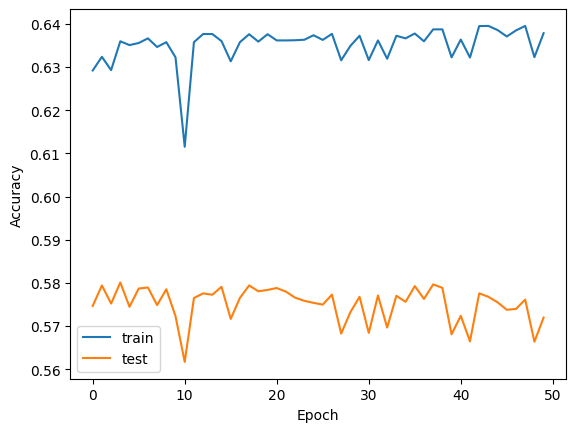

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_acc, test_acc, label1='train', label2='test'):
    x = np.arange(len(train_acc))
    plt.plot(x, train_acc, label=label1)
    plt.plot(x, test_acc, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습이 끝난 후, train_accs와 test_accs를 plot_acc 함수에 전달
plot_acc(train_accs, test_accs)